# Fixed Bias $R_{t}$ analysis

Analysis of results for a model with a fixed reporting bias based on a dirichlet prior, as well as an unknown, time-varying Rt value.

In [1]:
import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '14'

from periodic_sampling.synthetic_data import RenewalModel, Reporter

In [253]:
# Read in dataset

output = pd.read_csv("stan_inference_T_poisson_100_N0_100_R0diff_0.2_It_5000_seed_41.csv")
time_steps = 100; N_0 = 100; step_num=100; seed=41; R0_diff = 0.2; start_date = '01/01/2020'; bias_method = 'poisson'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))

np.random.seed(seed); model = RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

rep = Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease
truth_df = rep.unbiased_report(); bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

images_path = "stepped_profile/"

100%|██████████| 100/100 [00:00<00:00, 156679.27it/s]


In [254]:
def rename_col(col):
    col = col.replace('.', '_')
    return col[:5] + str(int(col[5:])-1) if col.startswith('bias') else col

output.columns = map(rename_col, output.columns)  # Only run this once!

Bias_0: 0.49 +/- 0.01
Bias_1: 1.42 +/- 0.03
Bias_2: 1.24 +/- 0.03
Bias_3: 1.06 +/- 0.02
Bias_4: 1.12 +/- 0.03
Bias_5: 1.05 +/- 0.02
Bias_6: 0.62 +/- 0.02


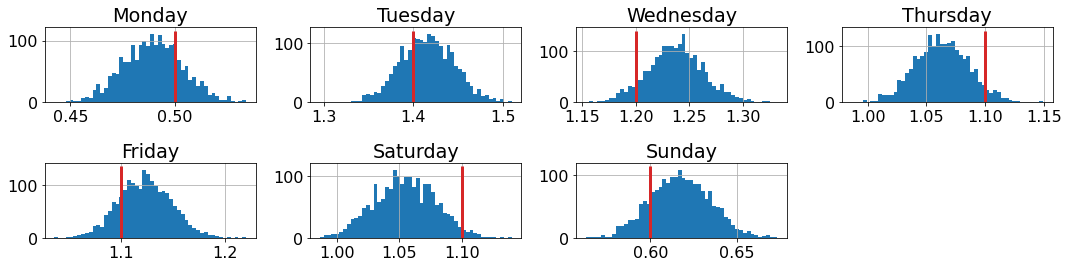

In [255]:
plt.rcParams['font.size'] = '16'

start_index = datetime.datetime.strptime(start_date, "%d/%m/%Y").weekday() - 1
output_bias = [np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 1) for i in range(7)]

histos = output.hist([("bias_" + str((i - start_index) % 7)) for i in range(7)], bins=50, figsize=(15, 4), layout=(2,4));
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(7):
    histos.flatten()[i].set_title(weekdays[i])
    histos.flatten()[i].vlines(x=bias[i], ymin=0, ymax=histos.flatten()[i].get_ylim()[1], color='tab:red', linewidth=3)
plt.gcf().patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig(images_path + f"biases_only_posterior_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seeds_{seed}.png")

for i in range(7):
    mean = np.round(np.mean(output['bias_' + str((i - start_index) % 7)]), 2)
    std = np.round(np.std(output['bias_' + str((i - start_index) % 7)]), 2)
    print(f"Bias_{i}: {mean} +/- {std}")

In [245]:
print(start_index)

1


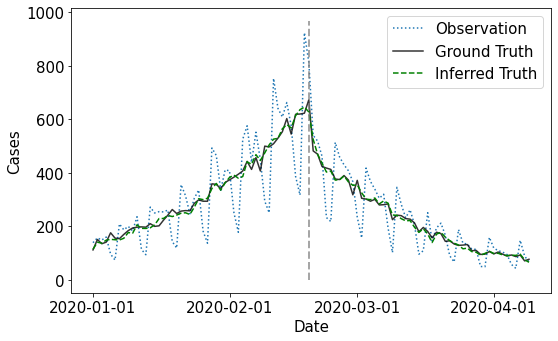

In [256]:
plt.rcParams['font.size'] = '15'
predicted_truth = []  

for index in range(1, time_steps + 1):
    predicted_truth.append(np.mean(output['I_' + str(index)]))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=ax, color='tab:blue', label = 'Observation', linestyle = 'dotted')
truth_df.plot(x='Date', y='Confirmed', ax=ax, color='black', label = 'Ground Truth', alpha=0.8)
ax.plot(truth_df['Date'], predicted_truth, color='green', label = 'Inferred Truth', linestyle = 'dashed')

mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
ax.vlines(x=mid_date, ymin=0, ymax=ax.get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases")
plt.legend(); plt.tight_layout()
# plt.savefig(images_path + f"biased_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

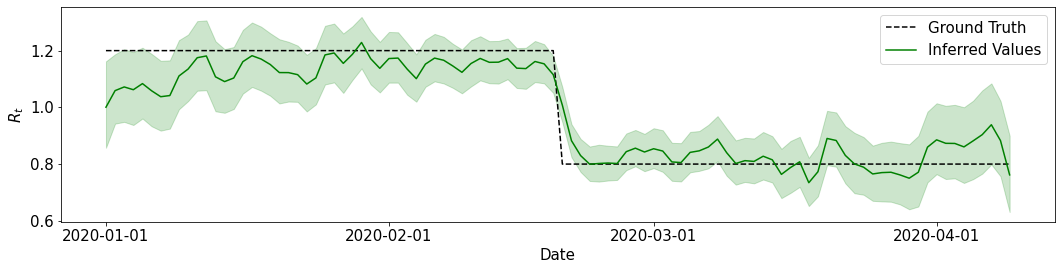

In [257]:
plt.rcParams['font.size'] = '15'; interval_range = 90; window = 0
predicted_R = []; upper_R = []; lower_R = []
percentile = (100-interval_range) / 2


for index in range(1, time_steps+1):
    predicted_R.append(np.mean(output['R_' + str(index)]))
    upper_R.append(np.percentile(output['R_' + str(index)], 100-percentile))
    lower_R.append(np.percentile(output['R_' + str(index)], percentile))

# Plot bias in data
fig, ax = plt.subplots(1, figsize=(15, 4))

ax.plot(truth_df['Date'][window:], R0_list[window:], color='black', label = 'Ground Truth', linestyle = 'dashed')
ax.plot(truth_df['Date'][window:], predicted_R[window:], color='green', label = 'Inferred Values')
ax.fill_between(truth_df['Date'][window:], lower_R[window:], upper_R[window:], color = 'green', alpha=0.2)

ax.set_xticks(ax.get_xticks()[::2]);
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("$R_{t}$")
plt.legend(); plt.tight_layout()
# plt.savefig(images_path + f"Rt_reconstruction_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

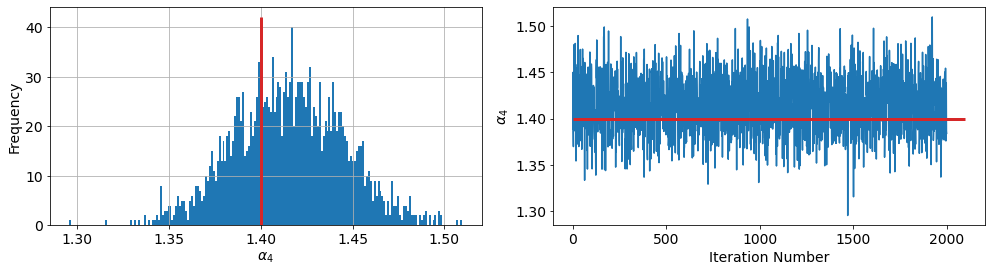

In [248]:
i = 0; bias_x = 'bias_' + str(i)
value = 1.4; bias_name = 'alpha{' + str(i) + '}'

plt.rcParams['font.size'] = '14'
fig, axs = plt.subplots(1, 2, figsize=(14,4))

histo = output.hist(bias_x, ax=axs[0], bins=200)
axs[0].vlines(x=value, ymin=0, ymax=axs[0].get_ylim()[1], color='tab:red', linewidth=3)
axs[0].set_xlabel(r'$\alpha_{4}$'); axs[0].set_ylabel('Frequency'); axs[0].set_title('');

if ('Chain' in output.columns):
    chains = output['Chain'].unique()
    for chain in chains:
        index = output.index[output['Chain']==chain]
        # axs[1].plot(index % len(index), output[bias_x][output['Chain']==chain])
        axs[1].plot((pd.Series([x for x in range(len(index) + 1)]) % len(index + 1))[:-1],
                    (pd.concat([pd.Series([1.2]), output[bias_x][output['Chain']==chain]]))[:-1], alpha=0.7)
else:
    axs[1].plot(output.index, output[bias_x])
axs[1].hlines(y=value, xmin=0, xmax=axs[1].get_xlim()[1], color='tab:red', linewidth=3)
axs[1].set_xlabel('Iteration Number'); axs[1].set_ylabel(r'$\alpha_{4}$'); axs[0].set_title('');

plt.gcf().patch.set_facecolor('white'); plt.tight_layout();
# plt.savefig(images_path + f"{bias_x}_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

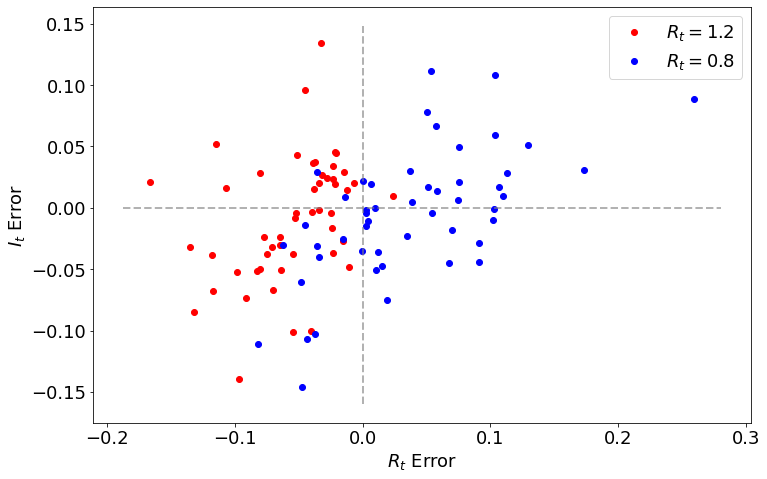

In [258]:
plt.rcParams['font.size'] = '18'
colors = ['r', 'b']; R_val = [1 + R0_diff, 1 - R0_diff]

if 'R_1' in output.columns:
    fig, axs = plt.subplots(1, 1, figsize=(11,7))
    for t in range(time_steps):
        if ('Chain' not in output.columns):
            output['Chain'] = 1
        chains = output['Chain'].unique()
        for chain in chains:
            index = output.index[output['Chain']==chain]
            axs.plot(
                np.mean((output['R_' + str(t+1)][output['Chain']==chain]) - R_val[t // int(time_steps /2)]) / R_val[t // int(time_steps /2)],
                # np.mean(output['bias_' + str(t % 7)][output['Chain']==chain]) - bias[(t + start_index) % 7],
                (np.mean(output['I_' + str(t+1)][output['Chain']==chain]) - truth_df['Confirmed'][t]) / truth_df['Confirmed'][t],
                marker='o', color = colors[t // int(time_steps /2)], linestyle = '')

    axs.hlines(y=0, xmin=axs.get_xlim()[0], xmax=axs.get_xlim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.vlines(x=0, ymin=axs.get_ylim()[0], ymax=axs.get_ylim()[1], color='gray', linewidth=2, alpha=0.6, linestyle='dashed')
    axs.set_xlabel(r'$R_{t}$ Error'); axs.set_ylabel(r'$I_{t}$ Error'); axs.set_title('');
    axs.lines[1].set_label(r'$R_{t} = 1.2$'); axs.lines[-1].set_label(r'$R_{t} = 0.8$')

    plt.gcf().patch.set_facecolor('white'); plt.legend(); plt.tight_layout();
    # plt.savefig(images_path + f"error_distribution_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

RMS Residual for Biased data: 98.42
RMS Residual for Rolling Average data: 43.25
RMS Residual for Bayesian Inference data: 13.77


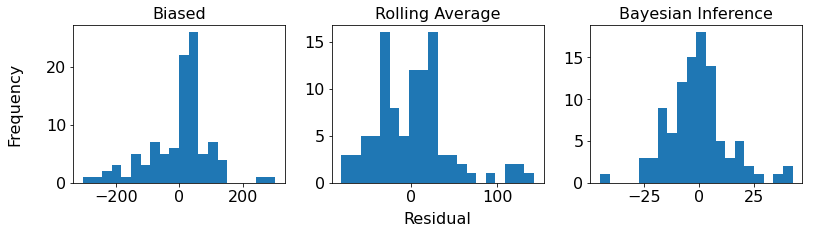

In [250]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()
data_series = [bias_df['Confirmed'], roll_ave_series, predicted_truth]
labels = ['Biased', 'Rolling Average', 'Bayesian Inference']
font_size = 16

fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    residual = data_series[i] - truth_df['Confirmed']
    axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_residuals_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")

Expected lag for Biased data: 0.08 days
Expected lag for Rolling Average data: 1.90 days
Expected lag for Bayesian Inference data: 0.08 days


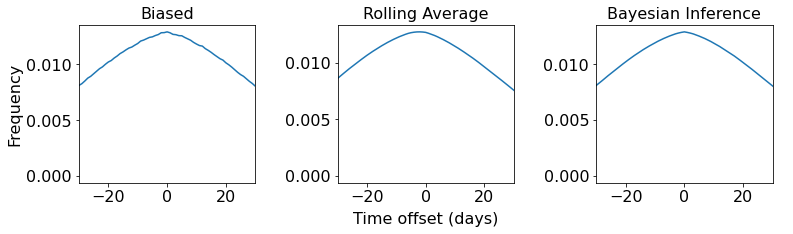

In [251]:
fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
for i in range(len(data_series)):
    cross_corr = np.correlate(truth_df['Confirmed'], data_series[i], mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    t_values = range(-len(truth_df['Confirmed']) + 1, len(truth_df['Confirmed']))
    expected_lag = np.dot(t_values, cross_corr)
    
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  # Normalise by number of contributing elements from timeseries
    axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
    axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
    axs[i].tick_params(axis='both', which='major', labelsize=font_size)
    print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
plt.tight_layout()
# plt.savefig(images_path + f"series_crosscorr_{bias_method}_T_{time_steps}_N0_{N_0}_R0diff_{R0_diff}_It_{step_num}_seed_{seed}.png")